<a href="https://colab.research.google.com/github/KeyboarderSon/TIL/blob/main/SimpleSTT/SpeechToText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/

##Audio waves 전처리

앞서 살펴보았듯,
 녹음본의 길이가 1초 이하고 sampling rate은 너무 높았다.<br>
그래서 resampling을 해보겠다.

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
ROOT="/content/drive"
MY_GOOGLE_DRIVE_PATH="MyDrive/SimpleSTT/data"
PROJECT_PATH=os.path.join(ROOT, MY_GOOGLE_DRIVE_PATH)
drive.mount(ROOT)

train_audio_path = PROJECT_PATH+'/train/audio'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]


all_wave=[]
all_label=[]


아래 작업이 시간이 오래 걸려서 한 라벨에 대해 처리가 끝나면 npy 파일로 저장해 내보냈다.

In [4]:

for label in labels:
  print(label)
  waves=[f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
  for wav in waves:
    samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    if(len(samples)==8000):
      all_wave_test.append(samples)
      all_label_test.append(label)


  np.save(PROJECT_PATH+'/train/SaveArr/'+label,np.array(all_wave))
  np.save(PROJECT_PATH+'/train/SaveArr/'+label+'_label',np.array(all_label))


 위에서 저장했던 Array를 load한다.

In [8]:
all_wave=[]
all_label=[]
NPY_PATH=PROJECT_PATH+'/train/SaveArr/'

for label in  labels:
  all_wave.extend(np.load(NPY_PATH+label+'.npy'))
  all_label.extend(np.load(NPY_PATH+label+'_label.npy'))

### categorical 데이터를 numerical로 변환하기

**LabelEncoder**
을 사용하면,<br>
숫자형으로 리턴될 뿐만 아니라
그 숫자가 어떠한 class를 나타내는지도 알 수 있다.

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)

#변환된 label classes 확인
classes = list(le.classes_)


우리는 지금 **multi-classification 문제**를 다루고 있기에 interger encoded label을 one-hot vector로 변환한다.

In [10]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

conv1d의 input array는 3 dimension이기 때문에 우리는 2D array를 3D array로 변환한다.

In [11]:
all_wave = np.array(all_wave).reshape(-1, 8000, 1)

train set(80%)과 validation set(20%)으로 나누기

```
stratify는 계층적 데이터 추출 옵션이다.

분류 모델에서 추천!!

여러 층으로 분할 후 각 층별로 랜덤 데이터를 추출한다. 원래 데이터의 분포와 유사하게 데이터를 추출한다.
```

In [12]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(all_wave), np.array(y),
    stratify = y, test_size = 0.2,
    random_state = 777, shuffle=True
)


shape의 가장 왼쪽 숫자가 일치하는지 한번 확인해본다.

In [10]:
print(np.array(x_tr).shape, np.array(y_tr).shape)
print(np.array(x_val).shape, np.array(y_val).shape)


(93660, 8000, 1) (93660, 10)
(23415, 8000, 1) (23415, 10)


## 이제 진짜 모델을 만들어보자

` Input `→{`Conv1D`→`Max Pooling`}(x4)→`Dense`→`Output`

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
#(filter, kernel_size)
#filter : 출력 차원의 수
#kernel_size 합성곱이 적용되는 가로 길이
conv = Conv1D(8, 13, padding="valid", activation="relu", strides=1)(inputs)
# feature map의 크기를 줄이거나  주요한 특징을 뽑아내기 위해
conv = MaxPooling1D(3)(conv)
#input data의 30퍼센트의 노드들을 무작위로 0으로 만듦.
conv = Dropout(0.3)(conv)

conv = Conv1D(16, 11, padding='valid', activation = 'relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(32, 9, padding='valid', activation = 'relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(64, 7, padding='valid', activation = 'relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

multi classification을 다루고 있기에 loss function을 categorical cross entropy로 정의한다

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early Stopping과 model checkpoints는 매 epoch를 수행하면 best model을 저장하고 accuracy에 더이상 진전이 보이지 않으면 early stopping을 수행한다.

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

batch size는 32로 지정하고 training하고 
evaluate한다

In [14]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
2927/2927 [==============================] - 32s 8ms/step - loss: 1.5188 - accuracy: 0.4598 - val_loss: 0.5523 - val_accuracy: 0.8234

Epoch 00001: val_accuracy improved from -inf to 0.82345, saving model to best_model.hdf5
Epoch 2/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.6143 - accuracy: 0.7987 - val_loss: 0.3778 - val_accuracy: 0.8762

Epoch 00002: val_accuracy improved from 0.82345 to 0.87623, saving model to best_model.hdf5
Epoch 3/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.4662 - accuracy: 0.8481 - val_loss: 0.2839 - val_accuracy: 0.9080

Epoch 00003: val_accuracy improved from 0.87623 to 0.90797, saving model to best_model.hdf5
Epoch 4/100
2927/2927 [==============================] - 24s 8ms/step - loss: 0.3993 - accuracy: 0.8714 - val_loss: 0.2665 - val_accuracy: 0.9127

Epoch 00004: val_accuracy improved from 0.90797 to 0.91271, saving model to best_model.hdf5
Epoch 5/100
2927/2927 [========================

In [16]:
import json
with open(PROJECT_PATH+'/train/'+'history_file.json', 'w') as f:
  json.dump(history.history, f)

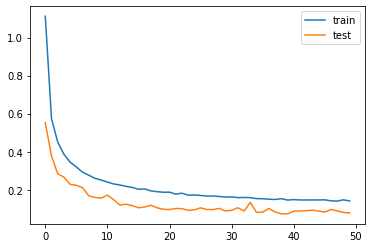

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


best model을 다시 사용가능할 수 있도록 내보냈고 이를 다시 load했다.

In [30]:
model.save(PROJECT_PATH+'/train/'+'my_model.h5')
load_model('best_model.hdf5').save(PROJECT_PATH+'/train/'+'best_model.hdf5')

In [6]:
from keras.models import load_model
model=load_model(PROJECT_PATH+'/train/'+'best_model.hdf5')


## Prediction 작업을 시작해보자

audio가 주어지면 text로 예측하는 함수를 만들어보자

In [7]:
def predict(audio):
  prob=model.predict(audio.reshape(1,8000,1))
  index=np.argmax(prob[0])
  return classes[index]

validation data에 관하여

In [13]:
import random
index=random.randint(0, len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:", classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text : ", predict(samples))

Audio: right
Text :  right


### 드디어 내 목소리로 Predict해보기

audacity로 1초동안 8000hz로 **down**과 **yes**를 녹음해서 wav파일로 저장했다.

In [31]:
samples, sample_rate=librosa.load(PROJECT_PATH+'/myvoice_down_1sec.wav', sr=16000)
samples=librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)
predict(samples)

'down'

In [44]:
samples, sample_rate=librosa.load(PROJECT_PATH+'/myvoice_yes_1sec.wav', sr=8000)
ipd.Audio(samples, rate=8000)
predict(samples)


'yes'

나의 목소리를 통해서도 잘 prediction 된다!!